In [1]:
import preprocessing
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor


In [72]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("project_05_02_v2")

2024/02/05 10:33:43 INFO mlflow.tracking.fluent: Experiment with name 'project_05_02_v2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/ifeol/Desktop/MASTERS/Project/Project/mlruns/5', creation_time=1707125623347, experiment_id='5', last_update_time=1707125623347, lifecycle_stage='active', name='project_05_02_v2', tags={}>

In [89]:
df4 = pd.read_excel('Data/new_acpc_newTotal.xlsx')
df4.describe()

,amplitude,pulsewidth,frequency,tip_x,tip_y,tip_z,contact_x,contact_y,contact_z,total_new
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,3.412941,104.823529,150.176471,0.237402,-2.638803,-3.940572,0.228204,-4.322712,-0.189468,60.904853
std,1.101724,41.580798,28.575107,19.679388,1.349121,1.909618,20.281298,1.608735,2.078624,30.350387
min,0.900000,60.000000,30.000000,-22.935472,-6.058409,-10.256144,-24.172991,-8.797719,-6.238426,0.000000
25%,2.600000,90.000000,130.000000,-19.622904,-3.405053,-5.108001,-20.240286,-5.253336,-1.510804,36.795000
50%,3.500000,90.000000,130.000000,15.056929,-2.827421,-3.869376,15.683606,-4.276447,-0.259933,66.670000
75%,4.100000,120.000000,180.000000,19.585422,-1.848672,-2.675272,20.117857,-3.144747,1.118216,86.287500
max,7.200000,240.000000,200.000000,23.023385,2.140558,0.321371,23.542087,0.631961,7.269295,100.000000


In [91]:
gen_df = df4[df4['type'] == 'GEN']
gen_df.describe()

cer_df = df4[df4['type'] == 'CER']
cer_df.describe()

,amplitude,pulsewidth,frequency,tip_x,tip_y,tip_z,contact_x,contact_y,contact_z,total_new
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,3.435294,109.647059,153.411765,0.237806,-2.811070,-3.823644,0.215407,-4.586017,-0.153513,59.369765
std,1.110202,47.010563,27.787585,19.685382,1.274586,1.927052,20.325384,1.627272,2.136955,29.258901
min,1.400000,60.000000,30.000000,-22.193090,-5.781929,-8.710269,-23.173988,-8.797719,-6.238426,0.000000
25%,2.500000,90.000000,130.000000,-19.491780,-3.534847,-5.089627,-20.226652,-5.427396,-1.547069,36.360000
50%,3.500000,90.000000,150.000000,13.777929,-2.949765,-3.799373,14.439577,-4.527719,-0.216296,63.640000
75%,4.100000,120.000000,180.000000,19.566552,-1.947539,-2.632477,20.183603,-3.599426,1.061799,84.620000
max,6.000000,240.000000,200.000000,23.023385,0.438336,0.321371,23.542087,-1.182053,7.269295,100.000000


C:\Users\ifeol\AppData\Local\Temp\ipykernel_16604\1235939970.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_df['total_class'] = pd.cut(gen_df['total_new'], bins=bins, labels=labels, right=False)
C:\Users\ifeol\AppData\Local\Temp\ipykernel_16604\1235939970.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cer_df['total_class'] = pd.cut(cer_df['total_new'], bins=bins, labels=labels, right=False)


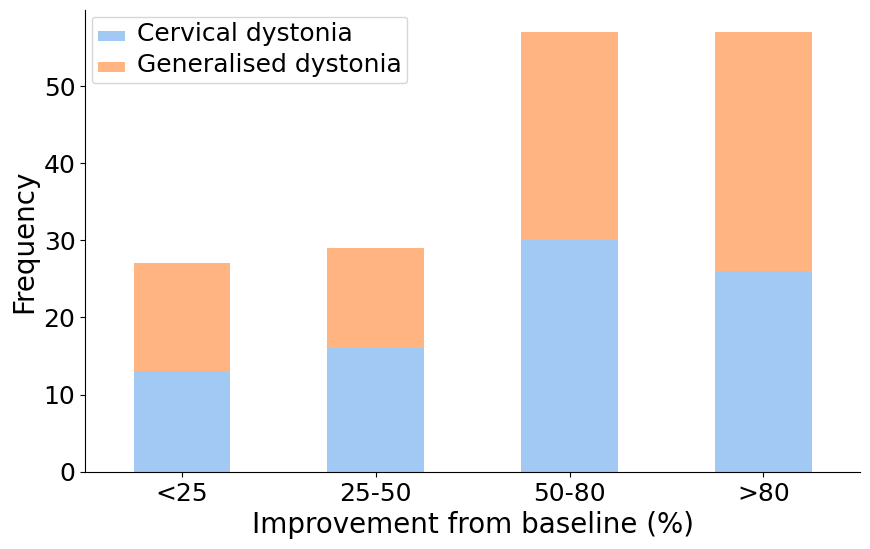

In [112]:
# Define the bins for categorization
bins = [0, 25, 50, 80, float('inf')]
labels = ['<25', '25-50', '50-80', '>80']

# Create a new column 'total_class' based on the bins
gen_df['total_class'] = pd.cut(gen_df['total_new'], bins=bins, labels=labels, right=False)
cer_df['total_class'] = pd.cut(cer_df['total_new'], bins=bins, labels=labels, right=False)

# Combine the two DataFrames for plotting
combined_df = pd.concat([gen_df, cer_df])

# Group by 'total_class', then count the occurrences for each type
grouped_df = combined_df.groupby(['total_class', 'type']).size().unstack(fill_value=0)

# Set a paler color palette
sns.set_palette("pastel")

# Plot the stacked bar chart without bounding box
ax = grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='none')

# Customize the plot
# plt.title('Stacked Bar Chart of Total by Total Class and Type')
plt.xlabel('Improvement from baseline (%)', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(rotation=0, fontsize=18)  # Rotate x-axis labels to be horizontal
plt.yticks(fontsize=18)
# plt.legend(loc='upper left') #title='Type', bbox_to_anchor=(0, 1), 

# Change legend labels
legend_labels = {'GEN': 'Generalised dystonia', 'CER': 'Cervical dystonia'}
for text in ax.legend().texts:
    text.set_text(legend_labels[text.get_text()])
    text.set_fontsize(18)

# Remove spines (bounding box around the plot)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# Show the plot
plt.show()


In [ ]:
for model_name, model in models.items():
    print(f"Performing GridSearchCV for {model_name}...")
    
    # Create GridSearchCV instance
    grid_search = GridSearchCV(estimator=model(), param_grid=parameters[model_name], cv=kfold_split, scoring='neg_mean_squared_error', n_jobs=-1, verbose =4, return_train_score=True)
    grid_search.fit(X, y)
    best_model = model(**grid_search.best_params_)
    best_model.fit(X, y)

    # Plotting feature importance for specific models that support it
    if model_name in ['Lasso Regression', 'Ridge']:
        coefs = pd.Series(best_model.coef_, index=features.columns)
        sorted_coefs = coefs.abs().sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sorted_coefs.plot(kind='barh', color='skyblue')
        plt.xlabel('Absolute Coefficient Value')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance from {model_name}')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    elif model_name == 'SVR':
        if best_model.kernel == 'linear':
            svm_coefs = pd.Series(best_model.coef_[0], index=features.columns)
            sorted_svm_coefs = svm_coefs.abs().sort_values(ascending=False)
            plt.figure(figsize=(10, 6))
            sorted_svm_coefs.plot(kind='barh')
            plt.title('Feature Importance from SVM with RBF Kernel')
            plt.show()
        else:
            # Fit the SVM model
            result = permutation_importance(best_model, X, y, n_repeats=10, random_state=42)
            importance = result.importances_mean
            plt.figure(figsize=(10, 6))
            sorted_idx = importance.argsort()
            plt.barh(features.columns[sorted_idx], importance[sorted_idx])
            plt.xlabel("Permutation Importance")
            plt.title("Permutation Importance from SVM with RBF Kernel")
            plt.show()

In [73]:
df1 = pd.read_excel('Data/new_mni_oldTotal.xlsx')
df2 = pd.read_excel('Data/new_acpc_oldTotal.xlsx')
df3 = pd.read_excel('Data/new_mni_newTotal.xlsx')
df4 = pd.read_excel('Data/new_acpc_newTotal.xlsx')
df1.describe()

df = {
    'new_mni_oldTotal': df1,
    'new_acpc_oldTotal': df2,
    'new_mni_newTotal': df3,
    'new_acpc_newTotal': df4
}

In [74]:
models = {
    'Lasso': Lasso,
    'Ridge': Ridge,
    'SVR': SVR,
    'RF': RandomForestRegressor,
    'xgboost': xgb.XGBRegressor
}

# Define hyperparameters for each 
parameters = {
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1.0],
        'max_iter': [100, 500, 700, 1000, 2000],
        'selection': ['cyclic', 'random']
    },
    'Ridge': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10]
    },
    
    'SVR': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    
    'RF': {
        'n_estimators': [2, 5, 10, 20, 50, 100, 200],  # , 200, 300
        'max_depth': [None, 5,10, 20, 25, 30],  #, 30
        # 'max_features': [1]  #, 'sqrt', 'log2'
    },
    'xgboost': {
        "max_depth":    [2,3, 4, 5, 6],
        "n_estimators": [500, 600, 700, 750, 800],
        "learning_rate": [0.001, 0.01, 0.1, 1]
    }
}

In [75]:
# for df_name, subset_df in df.items():
#     features = subset_df.iloc[:,:-1]
#     target = subset_df.iloc[:,-1]
#     ct = make_column_transformer(
#     (StandardScaler(), make_column_selector(dtype_include=np.number)),  
#     (OrdinalEncoder(categories='auto'), make_column_selector(dtype_include=object)))  
#     X = ct.fit_transform(features)
#     y= target

#     kfold_split = KFold(n_splits=5, shuffle=True, random_state=500)
#     kfold_split.get_n_splits(X)

#     loo = LeaveOneOut()
    
#     for model_name, model in models.items():
#         run_name = f"{df_name}_{model_name}"

#         with mlflow.start_run(run_name = run_name):
#             mlflow.set_tag("model_name", model_name)
            
#             mlflow.log_param("Dataset", df_name)
#             mlflow.log_param("Model", model_name)
#             mlflow.log_param("Features", features.columns)

#             print(f"Performing GridSearchCV for {model_name}...")
#             grid_search = GridSearchCV(estimator=model(), param_grid=parameters[model_name], cv=loo, scoring='neg_mean_squared_error', n_jobs=-1, verbose =4, return_train_score=True)

#             grid_search.fit(X, y)

#             train_model = model(**grid_search.best_params_)

#             loo_cv_scores = cross_val_score(train_model, X, y, cv=loo, scoring='neg_mean_squared_error', n_jobs=-1)
#             loo_avg_mse = -loo_cv_scores.mean()

#             mlflow.log_metric("LOO MSE", loo_avg_mse)
#             mlflow.sklearn.log_model(train_model, "model")


In [76]:
for df_name, subset_df in df.items():
    features = subset_df.iloc[:, :-1]
    target = subset_df.iloc[:, -1]
    ct = make_column_transformer(
        (StandardScaler(), make_column_selector(dtype_include=np.number)),
        (OrdinalEncoder(categories='auto'), make_column_selector(dtype_include=object))
    )
    X = ct.fit_transform(features)
    y = target

    kfold_split = KFold(n_splits=5, shuffle=True, random_state=500)
    kfold_split.get_n_splits(X)

    loo = LeaveOneOut()

    for model_name, model in models.items():
        run_name = f"{df_name}_{model_name}"

        with mlflow.start_run(run_name=run_name):
            mlflow.set_tag("model_name", model_name)

            mlflow.log_param("Dataset", df_name)
            mlflow.log_param("Model", model_name)
            mlflow.log_param("Features", features.columns)

            print(f"Performing GridSearchCV for {model_name}...")
            grid_search = GridSearchCV(estimator=model(), param_grid=parameters[model_name],
                                       cv=loo, scoring='neg_mean_squared_error', n_jobs=-1, verbose=4,
                                       return_train_score=True)

            grid_search.fit(X, y)

            best_params = grid_search.best_params_
            for param_name, param_value in best_params.items():
                mlflow.log_param(param_name, param_value)

            train_model = model(**grid_search.best_params_)

            loo_cv_scores = cross_val_score(train_model, X, y, cv=loo, scoring='neg_mean_squared_error', n_jobs=-1)
            loo_avg_mse = -loo_cv_scores.mean()

            mlflow.log_metric("LOO MSE", loo_avg_mse)
            mlflow.sklearn.log_model(train_model, "model")

            # Make predictions on the entire dataset
            train_model.fit(X, y)
            y_pred = train_model.predict(X)
            
            # Calculate percentage deviation
            percentage_deviation = np.abs(y_pred - y)            

            # Calculate average deviation and deviation range
            avg_deviation = np.mean(percentage_deviation)
            deviation_range = np.std(percentage_deviation)
            rmse = np.sqrt(np.mean((y_pred - y) ** 2))

            mlflow.log_metric("Average Deviation", avg_deviation)
            mlflow.log_metric("Deviation Range", deviation_range)
            mlflow.log_metric("RMSE", rmse)

            # Calculate percentage deviation excluding when y = 0
            mask = y != 0  # Avoid division by zero
            percentage_deviation_null = np.zeros_like(y)
            percentage_deviation_null[mask] = np.abs(y_pred[mask] - y[mask])

            # Calculate average deviation and deviation range
            avg_deviation_null = np.mean(percentage_deviation_null)
            deviation_range_null = np.std(percentage_deviation_null)
            rmse_null = np.sqrt(np.mean((y_pred - y) ** 2))

            mlflow.log_metric("Average Deviation-null", avg_deviation_null)
            mlflow.log_metric("Deviation Range-null", deviation_range_null)
            mlflow.log_metric("RMSE-null", rmse_null)

            print(f"The predictions deviated on average by {avg_deviation:.2f}+- {deviation_range:.2f} % from observed values.")


Performing GridSearchCV for Lasso...
Fitting 170 folds for each of 40 candidates, totalling 6800 fits
The predictions deviated on average by 23.79+- 15.67 % from observed values.
Performing GridSearchCV for Ridge...
Fitting 170 folds for each of 5 candidates, totalling 850 fits
The predictions deviated on average by 23.56+- 15.72 % from observed values.
Performing GridSearchCV for SVR...
Fitting 170 folds for each of 128 candidates, totalling 21760 fits
The predictions deviated on average by 19.76+- 15.94 % from observed values.
Performing GridSearchCV for RF...
Fitting 170 folds for each of 42 candidates, totalling 7140 fits
The predictions deviated on average by 17.29+- 11.79 % from observed values.
Performing GridSearchCV for xgboost...
Fitting 170 folds for each of 100 candidates, totalling 17000 fits
The predictions deviated on average by 18.96+- 12.78 % from observed values.
Performing GridSearchCV for Lasso...
Fitting 170 folds for each of 40 candidates, totalling 6800 fits
The 

In [77]:
print(y)
print(y_pred)

0      65.52
1      69.70
2       0.00
3      20.00
4       4.92
       ...  
165    46.10
166    90.90
167    90.90
168    75.00
169    75.00
Name: total_new, Length: 170, dtype: float64
[52.7381   53.680973 46.60807  58.396416 22.129353 44.16316  71.78228
 53.680973 53.680973 53.680973 32.885036 58.73995  56.22398  65.468506
 59.828186 54.975266 56.61944  45.644527 49.249504 56.52284  52.640617
 50.123936 52.107574 44.083572 45.44026  65.94832  65.01145  53.774227
 67.89416  42.577354 43.665676 48.479603 52.7381   61.590298 74.2065
 66.89184  57.842896 47.504135 52.547363 58.976505 60.964886 58.78577
 54.450584 67.07634  66.04362  55.028313 67.628845 68.295    73.7485
 60.66903  52.7381   55.556732 66.56611  78.04704  71.40395  77.30543
 82.55744  65.35512  70.73344  62.64517  56.165043 61.971516 64.35923
 61.590298 65.28101  67.77442  71.70888  43.100018 50.33005  59.54569
 53.680973 57.40404  68.172066 81.74157  81.71174  69.88822  69.88822
 71.49737  75.75836  55.668655 48.97739  

In [78]:
print(np.abs(y- y_pred))#/y

0      12.781902
1      16.019027
2      46.608070
3      38.396416
4      17.209353
         ...    
165     7.580973
166    11.682074
167    32.114230
168    10.787323
169    25.654217
Name: total_new, Length: 170, dtype: float64


In [79]:
a = list(np.abs(y- y_pred))
min(a)
np.mean(a)

# np.mean((np.abs(y- y_pred)/y)*100)

19.501624638276944

In [80]:
print(np.max(a))
print(np.min(a))

53.780513763427734
0.22183807373046704


In [81]:
np.std(a)

12.488193016160253

In [82]:
b = list(y- y_pred)
np.mean(b)
np.std(b)

23.15309041724608

In [83]:
np.ptp(a)

53.55867568969727